In [1]:
import os

os.environ["KAGGLE_USERNAME"] = "pavanmedarametla6"
os.environ["KAGGLE_KEY"] = "597bf13c49f7d0e0f9e9a392e40cfba7"

In [2]:
!pip install kaggle

In [8]:
!kaggle datasets download -d pavanmedarametla6/challenge-dl

100%|█████████████████████████████████████▉| 9.82G/9.82G [06:57<00:00, 31.2MB/s]
100%|██████████████████████████████████████| 9.82G/9.82G [06:57<00:00, 25.2MB/s]


In [4]:
!pip install numpy pandas

In [5]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
import zipfile
import os 
zip_file_path = 'challenge-dl.zip'
extracted_dir = 'data'

os.makedirs(extracted_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)


extracted_files = os.listdir(extracted_dir)
print("Contents of the extracted directory:", extracted_files)

FileNotFoundError: [Errno 2] No such file or directory: 'challenge-dl.zip'

In [8]:
import torch
from torch import nn
from pathlib import Path


image_path = Path("data/data")
train_dir = Path("data/data/train")
val_dir = Path("data/data/val")

train_dir, val_dir

(PosixPath('data/data/train'), PosixPath('data/data/val'))

In [10]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.png"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)
print(img.size)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

(671, 1024)
Random image path: data/data/train/reindeer/410.png
Image class: reindeer
Image height: 1024
Image width: 671


In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms



data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),  # Add random vertical flip
    transforms.RandomRotation(degrees=30),  # Add random rotation up to 30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Add color jitter
    transforms.ToTensor()
])

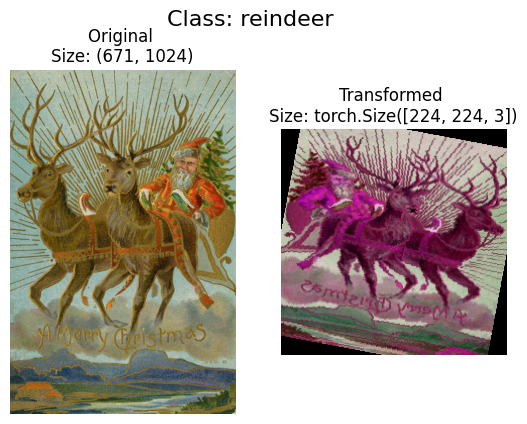

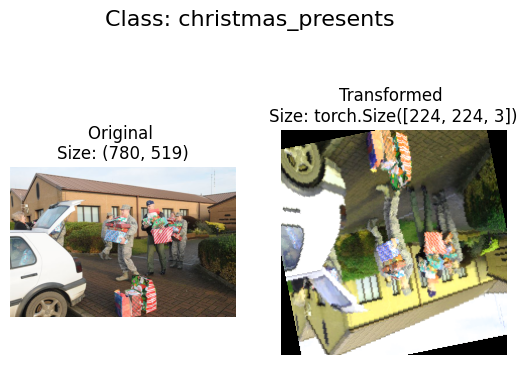

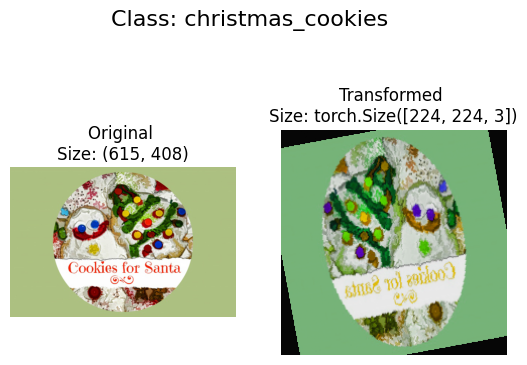

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

In [29]:
from torchvision import datasets
import torchvision.models as models
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

print(f"Train data:\n{train_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 3726
    Root location: data/data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
               ToTensor()
           )


In [30]:
class_names = train_data.classes
class_names

['christmas_cookies',
 'christmas_presents',
 'christmas_tree',
 'fireworks',
 'penguin',
 'reindeer',
 'santa',
 'snowman']

In [11]:
from torch import nn
import torchvision
import torch.nn.functional as F
import torch
class Network(nn.Module):

    def __init__(self):
        super().__init__()

        weights = torchvision.models.EfficientNet_B6_Weights.DEFAULT
        self.model = torchvision.models.efficientnet_b6(weights=weights)
        self.transform = weights.transforms()

        for param in self.model.features.parameters():
           param.requires_grad = False

        # Modify the final fully connected layer in the classifier
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        in_features = 2304
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.2, inplace=True),
            nn.Linear(in_features, 625),
            nn.ReLU(),
            nn.Linear(625, 256),
            nn.ReLU(),
            nn.Linear(256, 8)  
        )

    def forward(self, x):
        x = self.model(x)
        x = F.softmax(x, dim=1)  # Apply softmax along the class dimension
        return x

In [12]:
model= Network()
import torch
from torchinfo import summary
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
Network (Network)                                                 [32, 3, 224, 224]    [32, 8]              --                   Partial
├─EfficientNet (model)                                            [32, 3, 224, 224]    [32, 8]              --                   Partial
│    └─Sequential (features)                                      [32, 3, 224, 224]    [32, 2304, 7, 7]     --                   False
│    │    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 56, 112, 112]   (1,624)              False
│    │    └─Sequential (1)                                        [32, 56, 112, 112]   [32, 32, 112, 112]   (8,094)              False
│    │    └─Sequential (2)                                        [32, 32, 112, 112]   [32, 40, 56, 56]     (156,922)            False
│    │    └─Sequential (3)                     

In [16]:
import torch
from torchvision.models import efficientnet

# Load the pre-trained EfficientNet-B5 model
model = efficientnet.efficientnet_b4(pretrained=True)

# Display the model architecture
print(model)


/home/g057822/anaconda3/envs/mytask/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/g057822/anaconda3/envs/mytask/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [31]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

train_dataloader

In [21]:
resnet50 = models.resnet50(pretrained=True)
num_classes = 8  # Change this to the number of classes in your specific task
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)


/home/g057822/anaconda3/envs/mytask/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/g057822/anaconda3/envs/mytask/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/g057822/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 220MB/s]


In [18]:
import torchvision

weights = torchvision.models.EfficientNet_B4_Weights.DEFAULT
model = torchvision.models.efficientnet_b4(weights=weights)

auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[380]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [23]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    resnet50.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [24]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 50):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=resnet50,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)

    # 6. Return the filled results at the end of the epochs
    return results

/home/g057822/anaconda3/envs/mytask/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50

# Recreate an instance of TinyVGG
model_0 = resnet50.to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  2%|▏         | 1/50 [29:22<23:59:29, 1762.65s/it]

Epoch: 1 | train_loss: 1.6173 | train_acc: 0.4354 | 


  4%|▍         | 2/50 [53:42<21:07:29, 1584.36s/it]

Epoch: 2 | train_loss: 1.3009 | train_acc: 0.5388 | 


  6%|▌         | 3/50 [1:18:55<20:15:32, 1551.75s/it]

Epoch: 3 | train_loss: 1.1819 | train_acc: 0.5837 | 


  8%|▊         | 4/50 [1:37:13<17:32:19, 1372.60s/it]

Epoch: 4 | train_loss: 1.1099 | train_acc: 0.6164 | 


 10%|█         | 5/50 [1:50:33<14:34:33, 1166.08s/it]

Epoch: 5 | train_loss: 1.0005 | train_acc: 0.6466 | 


 12%|█▏        | 6/50 [2:10:01<14:15:37, 1166.76s/it]

Epoch: 6 | train_loss: 0.9685 | train_acc: 0.6535 | 


 14%|█▍        | 7/50 [2:21:27<12:03:31, 1009.56s/it]

Epoch: 7 | train_loss: 0.9221 | train_acc: 0.6820 | 


 16%|█▌        | 8/50 [2:31:30<10:16:11, 880.28s/it] 

Epoch: 8 | train_loss: 0.8915 | train_acc: 0.6902 | 


 18%|█▊        | 9/50 [2:41:02<8:55:35, 783.79s/it] 

Epoch: 9 | train_loss: 0.8455 | train_acc: 0.7108 | 


 20%|██        | 10/50 [2:49:35<7:46:50, 700.27s/it]

Epoch: 10 | train_loss: 0.8119 | train_acc: 0.7176 | 


 22%|██▏       | 11/50 [3:01:37<7:39:36, 707.08s/it]

Epoch: 11 | train_loss: 0.7561 | train_acc: 0.7375 | 


 24%|██▍       | 12/50 [3:15:27<7:51:21, 744.24s/it]

Epoch: 12 | train_loss: 0.7233 | train_acc: 0.7579 | 


 26%|██▌       | 13/50 [3:31:38<8:21:19, 812.96s/it]

Epoch: 13 | train_loss: 0.7378 | train_acc: 0.7462 | 


 28%|██▊       | 14/50 [3:46:44<8:24:41, 841.16s/it]

Epoch: 14 | train_loss: 0.6722 | train_acc: 0.7720 | 


 30%|███       | 15/50 [4:01:51<8:22:17, 861.07s/it]

Epoch: 15 | train_loss: 0.6703 | train_acc: 0.7726 | 


 32%|███▏      | 16/50 [4:18:09<8:27:46, 896.06s/it]

Epoch: 16 | train_loss: 0.6405 | train_acc: 0.7814 | 


 34%|███▍      | 17/50 [4:33:05<8:12:51, 896.10s/it]

Epoch: 17 | train_loss: 0.6437 | train_acc: 0.7744 | 


 36%|███▌      | 18/50 [4:49:15<8:09:44, 918.28s/it]

Epoch: 18 | train_loss: 0.6058 | train_acc: 0.7875 | 


 38%|███▊      | 19/50 [5:04:56<7:58:00, 925.19s/it]

Epoch: 19 | train_loss: 0.5941 | train_acc: 0.7946 | 


 40%|████      | 20/50 [5:25:44<8:30:59, 1021.98s/it]

Epoch: 20 | train_loss: 0.5635 | train_acc: 0.8107 | 


 42%|████▏     | 21/50 [5:46:58<8:50:32, 1097.67s/it]

Epoch: 21 | train_loss: 0.5464 | train_acc: 0.8077 | 


 44%|████▍     | 22/50 [6:06:41<8:44:13, 1123.32s/it]

Epoch: 22 | train_loss: 0.5232 | train_acc: 0.8212 | 


 46%|████▌     | 23/50 [6:26:37<8:35:17, 1145.11s/it]

Epoch: 23 | train_loss: 0.5074 | train_acc: 0.8262 | 


 48%|████▊     | 24/50 [6:48:05<8:34:53, 1188.20s/it]

Epoch: 24 | train_loss: 0.5331 | train_acc: 0.8171 | 


 50%|█████     | 25/50 [7:15:10<9:09:35, 1319.03s/it]

Epoch: 25 | train_loss: 0.4843 | train_acc: 0.8352 | 


 52%|█████▏    | 26/50 [7:41:43<9:20:32, 1401.36s/it]

Epoch: 26 | train_loss: 0.4741 | train_acc: 0.8393 | 


 54%|█████▍    | 27/50 [7:50:09<7:14:08, 1132.56s/it]

Epoch: 27 | train_loss: 0.4723 | train_acc: 0.8385 | 


 56%|█████▌    | 28/50 [7:58:10<5:43:41, 937.35s/it] 

Epoch: 28 | train_loss: 0.4522 | train_acc: 0.8472 | 


 58%|█████▊    | 29/50 [8:06:14<4:40:25, 801.23s/it]

Epoch: 29 | train_loss: 0.4462 | train_acc: 0.8430 | 


 60%|██████    | 30/50 [8:14:35<3:57:00, 711.02s/it]

Epoch: 30 | train_loss: 0.4440 | train_acc: 0.8503 | 


 62%|██████▏   | 31/50 [8:22:52<3:24:51, 646.91s/it]

Epoch: 31 | train_loss: 0.4490 | train_acc: 0.8449 | 


 64%|██████▍   | 32/50 [8:32:03<3:05:25, 618.09s/it]

Epoch: 32 | train_loss: 0.4193 | train_acc: 0.8584 | 


 66%|██████▌   | 33/50 [8:40:21<2:44:57, 582.22s/it]

Epoch: 33 | train_loss: 0.4265 | train_acc: 0.8520 | 


 68%|██████▊   | 34/50 [8:48:39<2:28:27, 556.72s/it]

Epoch: 34 | train_loss: 0.3744 | train_acc: 0.8692 | 


 70%|███████   | 35/50 [8:56:55<2:14:40, 538.72s/it]

Epoch: 35 | train_loss: 0.3710 | train_acc: 0.8731 | 


 72%|███████▏  | 36/50 [9:04:58<2:01:47, 521.94s/it]

Epoch: 36 | train_loss: 0.3835 | train_acc: 0.8639 | 


 74%|███████▍  | 37/50 [9:13:07<1:50:57, 512.12s/it]

Epoch: 37 | train_loss: 0.3431 | train_acc: 0.8821 | 


 76%|███████▌  | 38/50 [9:21:25<1:41:32, 507.73s/it]

Epoch: 38 | train_loss: 0.3690 | train_acc: 0.8723 | 


 78%|███████▊  | 39/50 [9:29:56<1:33:16, 508.73s/it]

Epoch: 39 | train_loss: 0.3593 | train_acc: 0.8777 | 


 80%|████████  | 40/50 [9:37:49<1:23:01, 498.17s/it]

Epoch: 40 | train_loss: 0.3365 | train_acc: 0.8932 | 


 82%|████████▏ | 41/50 [9:46:40<1:16:11, 507.98s/it]

Epoch: 41 | train_loss: 0.3648 | train_acc: 0.8735 | 


 84%|████████▍ | 42/50 [9:56:09<1:10:10, 526.35s/it]

Epoch: 42 | train_loss: 0.3232 | train_acc: 0.8885 | 


 86%|████████▌ | 43/50 [10:04:11<59:49, 512.78s/it] 

Epoch: 43 | train_loss: 0.3354 | train_acc: 0.8822 | 


 88%|████████▊ | 44/50 [10:12:19<50:32, 505.44s/it]

Epoch: 44 | train_loss: 0.3187 | train_acc: 0.8968 | 


 90%|█████████ | 45/50 [10:20:19<41:28, 497.72s/it]

Epoch: 45 | train_loss: 0.2991 | train_acc: 0.8976 | 


 92%|█████████▏| 46/50 [10:28:21<32:52, 493.14s/it]

Epoch: 46 | train_loss: 0.2689 | train_acc: 0.9073 | 


 94%|█████████▍| 47/50 [10:36:28<24:34, 491.41s/it]

Epoch: 47 | train_loss: 0.2683 | train_acc: 0.9072 | 


 96%|█████████▌| 48/50 [10:44:37<16:21, 490.51s/it]

Epoch: 48 | train_loss: 0.2816 | train_acc: 0.9078 | 


 98%|█████████▊| 49/50 [10:52:43<08:09, 489.34s/it]

Epoch: 49 | train_loss: 0.2522 | train_acc: 0.9183 | 


100%|██████████| 50/50 [11:01:21<00:00, 793.63s/it]

Epoch: 50 | train_loss: 0.2896 | train_acc: 0.9026 | 
Total training time: 39681.658 seconds


In [8]:
import os 
from PIL import Image
test_folder = "data/data/val"
image_files = [f for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f))]

In [9]:
for image_file in image_files:
    # Load and preprocess the image
    #print(image_file)
    image_path = os.path.join(test_folder, image_file)
    image = Image.open(image_path)
    
    # Get the number of channels
    num_channels = len(image.getbands())
    
    # Check if the number of channels is not 3
    if num_channels != 3:
        print(f"Warning: {image_file} has channels other than 3.")

    # Continue with the rest of your preprocessing...


In [26]:
for image_file in image_files:
    # Load and preprocess the image
    
    image_path = os.path.join(test_folder, image_file)
    image = Image.open(image_path)
    
    # Get the number of channels
    num_channels = len(image.getbands())
    
    # print(f"Number of channels in {image_file}: {num_channels}")
    # print(f"Image size: {image.size}")
    
    # Check if the number of channels is not 3
    if num_channels != 3:
        print(f"Warning: {image_file} has {num_channels} channels.")
        
        # Extract and print specific information for these images
        if image_file in ["122.png", "18.png", "56.png", "6.png", "78.png", "90.png"]:
            print(f"Details for {image_file}: {image.getbands()}")
        
        # Continue with the rest of your preprocessing...


